In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm
from scipy import special

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [6]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
                'logit_rho': special.logit(.8)
                }
    
    true_params['log_both'] = np.log(0.6475) + true_params['log_scale']
                
else:

#     Daily
     true_params ={'log_both': -3,
                   'log_scale': -2.3,
                   'logit_rho': special.logit(.6),
                   'phi': -0.3,
                    'pi': -2.3, 
                   'theta': 0.15}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 2_000
sim_dim = 500
innov_dim = 200

In [7]:
bounds = {'pi': {'max': 0, 'min':-16, 'dim':17}, 'phi': {'max': -.25, 'min':-.4, 'dim':5}, 
          'theta': {'max':10, 'min': 0, 'dim':17}}

In [8]:
total_true_params = true_params.copy()
total_true_params['psi'] = vl.compute_psi(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                          theta=true_params['theta'])
total_true_params['beta'] = vl.compute_beta(logit_rho=true_params['logit_rho'], 
                                            log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'])
total_true_params['gamma'] = vl.compute_gamma(log_scale=true_params['log_scale'], phi=true_params['phi'],
                                            pi=true_params['pi'],theta=true_params['theta'],
                                            psi=total_true_params['psi'], log_both=true_params['log_both'])
total_true_params['zeta'] = 1 - true_params['phi']**2                                           

In [9]:
vl.compute_moments(psi=total_true_params['psi'], log_scale=true_params['log_scale'],
                   log_both=true_params['log_both'], logit_rho=true_params['logit_rho'],
                  pi=true_params['pi'], phi=true_params['phi'], theta=true_params['theta'])

{'return_mean': 0.02034864625098453,
 'return_var': 0.017873157660876243,
 'vol_mean': 0.012759894000000006,
 'vol_var': 0.0002514515751216002}

In [10]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [11]:
data.vol.describe()

count    2000.000000
mean        0.013290
std         0.017194
min         0.000010
25%         0.002393
50%         0.007550
75%         0.017382
max         0.143577
Name: vol, dtype: float64

In [12]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [13]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [14]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

In [15]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [16]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

## We start by examining the distributions of simulated data

In [17]:
data.corr()

,vol,rtn
vol,1.000000,-0.011106
rtn,-0.011106,1.000000


In [18]:
data.head()

,vol,rtn
2000-01-01,0.019625,-0.074545
2000-01-02,0.019583,0.159070
2000-01-03,0.029653,-0.082957
2000-01-04,0.007761,0.145897
2000-01-05,0.005770,-0.068596


In [19]:
data.vol.var()

0.00029563471764907463

In [20]:
vl.compute_vol_gmm(data.vol)

({'log_both': -6.025609097298583,
  'log_scale': -5.53840359676506,
  'logit_rho': 1.5119445371154698},
            log_both  log_scale  logit_rho
 log_both   0.007787   0.000996  -0.008862
 log_scale  0.000996   0.003099   0.000618
 logit_rho -0.008862   0.000618   0.022072)

In [21]:
omega, omega_cov = vl.estimate_params(data)

In [22]:
omega

{'gamma': 0.01240077376681976,
 'beta': 4.021463897062466,
 'psi': -3.351154674630051,
 'zeta': 0.820626940191704,
 'log_both': -6.025609097298583,
 'log_scale': -5.53840359676506,
 'logit_rho': 1.5119445371154698}

In [23]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.008676,-2.770054e-05,0.000000,0.000000,0.000000,-0.006580,0.000000
gamma,-0.000028,2.746010e-07,0.000000,0.000000,0.000000,0.000007,0.000000
log_both,0.000000,0.000000e+00,0.007787,0.000996,-0.008862,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000996,0.003099,0.000618,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.008862,0.000618,0.022072,0.000000,0.000000
psi,-0.006580,6.997692e-06,0.000000,0.000000,0.000000,0.036989,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000715


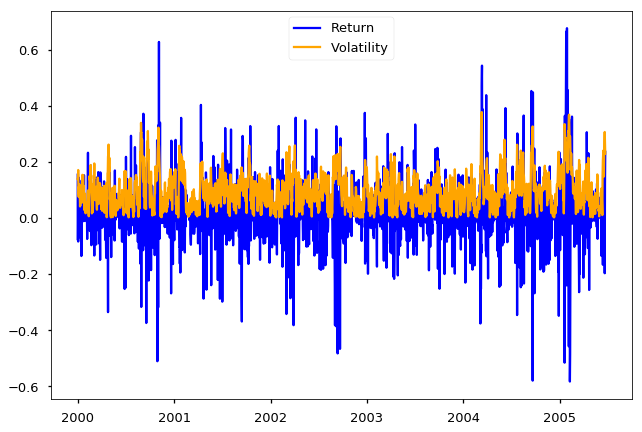

In [24]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [25]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.003992,-0.000092
rtn,-0.000092,0.012495


In [26]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

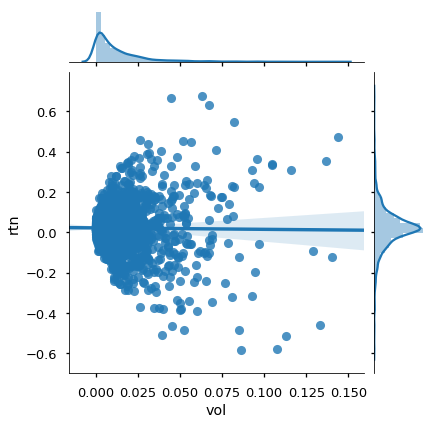

In [27]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [28]:
data.describe()

,vol,rtn
count,2000.000000,2000.000000
mean,0.013290,0.021191
std,0.017194,0.111780
min,0.000010,-0.582599
25%,0.002393,-0.023893
50%,0.007550,0.021180
75%,0.017382,0.068959
max,0.143577,0.678310


## I now estimate all of the parameters

In [29]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [30]:
vl.compute_init_constants(data.vol)

{'log_both': -6.062037124983186,
 'log_scale': -5.553679295051841,
 'logit_rho': 1.5554986165801874}

In [31]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [32]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [33]:
vl.compute_init_constants(data.vol)

{'log_both': -6.062037124983186,
 'log_scale': -5.553679295051841,
 'logit_rho': 1.5554986165801874}

In [34]:
vl.compute_vol_gmm(data_arr[0].vol)

({'log_both': -6.050041523710515,
  'log_scale': -5.53386615241408,
  'logit_rho': 1.4211265479978},
            log_both  log_scale  logit_rho
 log_both   0.006737   0.001204  -0.007057
 log_scale  0.001204   0.001831  -0.000954
 logit_rho -0.007057  -0.000954   0.018504)

In [35]:
# with Pool(8) as pool:
#     est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.compute_vol_gmm, [data.vol for data in data_arr]),
#                                       total=len(data_arr)))

In [36]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'logit_rho']]

In [37]:
# ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
#             for est in est_arr]

In [38]:
# vol_fig, vol_ax = mpl.pyplot.subplots()
# sns.distplot(ar_stats, ax=vol_ax)
# vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
# vol_ax.set_xlim([0,20])
# vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
# vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [39]:
# 100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

In [40]:
# t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
#             for est in est_arr for name in ['logit_rho', 'log_scale', 'log_both']]
# t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [41]:
# true_params['log_both']

In [42]:
# np.amin([est[0]['log_both'] for est in est_arr])

In [43]:
# t_stats_df.describe()

In [44]:
# for name, col in t_stats_df.items():
#     fig, ax = mpl.pyplot.subplots()
#     sns.distplot(col, ax=ax)
#     ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
#     ax.set_xlim([-4,4])

In [45]:
estimator = partial(vl.estimate_params_strong_id, bounds=bounds)

In [46]:
estimator(data_arr[0])

({'gamma': 0.012213304229061061,
  'beta': 4.10120607131474,
  'psi': -3.1984659899470462,
  'zeta': 0.7999589370873977,
  'log_both': -6.050041523710515,
  'log_scale': -5.53386615241408,
  'logit_rho': 1.4211265479978,
  'phi': -0.4,
  'pi': -11.982091493846488,
  'theta': 2.015057951120624},
                beta         gamma  log_both  log_scale  logit_rho       phi  \
 beta       0.013543 -3.836032e-05  0.000000   0.000000   0.000000       NaN   
 gamma     -0.000038  2.960526e-07  0.000000   0.000000   0.000000       NaN   
 log_both   0.000000  0.000000e+00  0.006737   0.001204  -0.007057       NaN   
 log_scale  0.000000  0.000000e+00  0.001204   0.001831  -0.000954       NaN   
 logit_rho  0.000000  0.000000e+00 -0.007057  -0.000954   0.018504       NaN   
 phi             NaN           NaN       NaN        NaN        NaN  0.000989   
 pi              NaN           NaN       NaN        NaN        NaN -0.357257   
 psi       -0.010519  1.493783e-05  0.000000   0.000000   0.0000

In [47]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [48]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [49]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   logit_rho=true_params['logit_rho'], 
                                                   log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

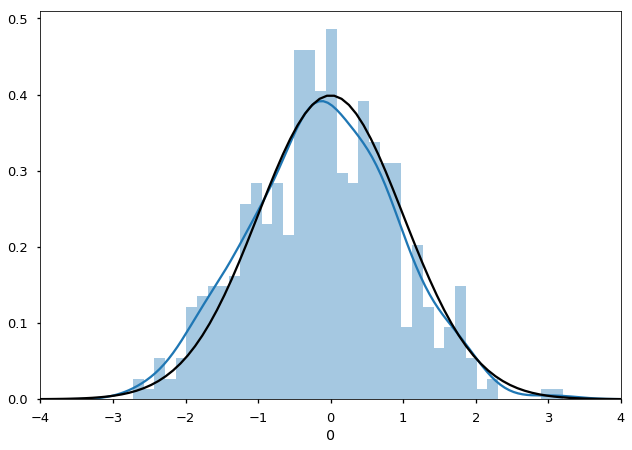

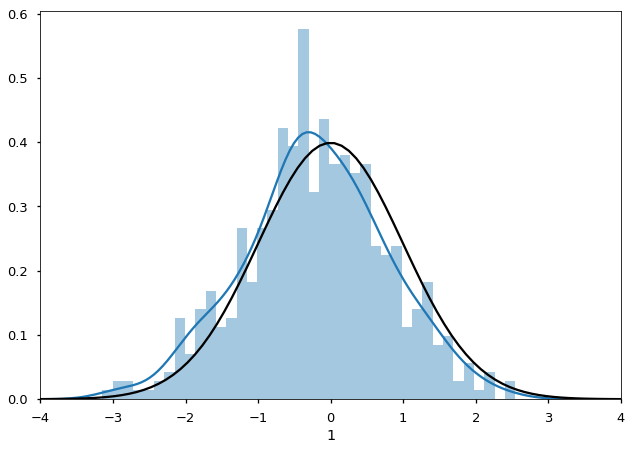

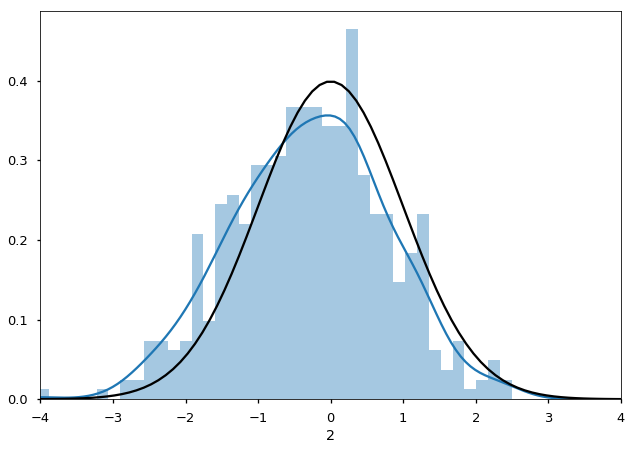

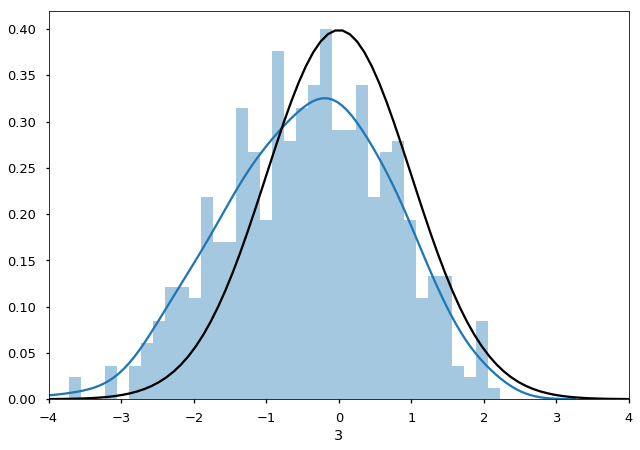

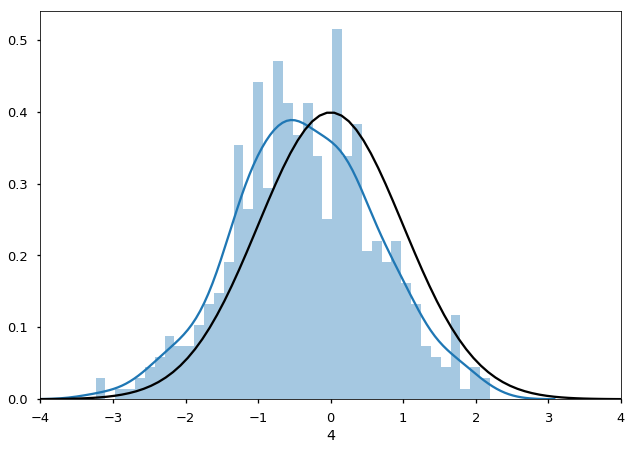

In [50]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

In [51]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413,
 'psi': -3.44020732020312,
 'beta': 4.076658793315891,
 'gamma': 0.012227592917921713,
 'zeta': 0.84}

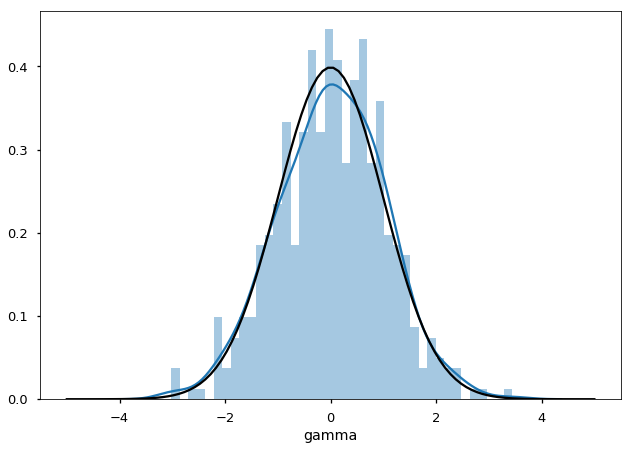

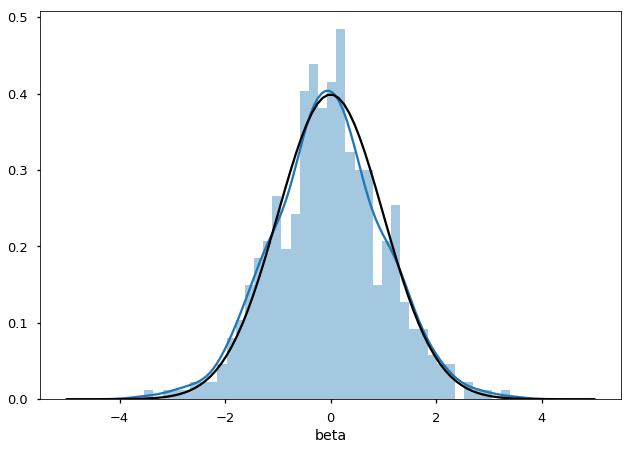

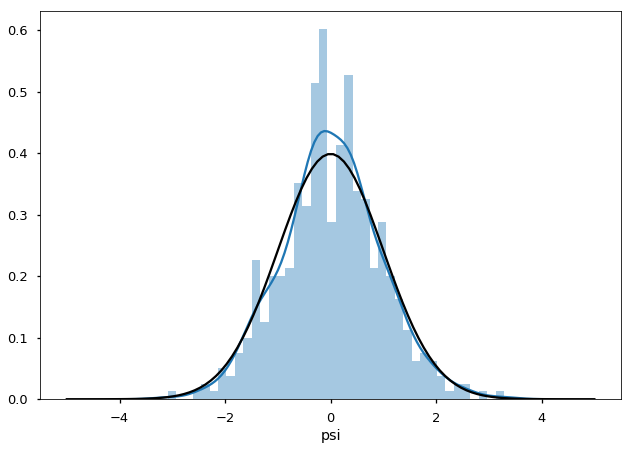

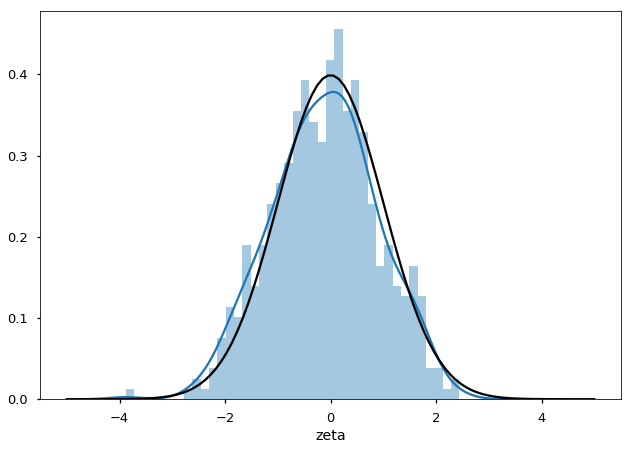

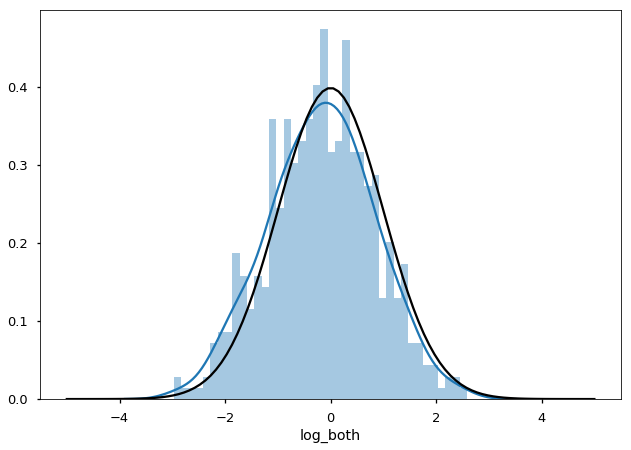

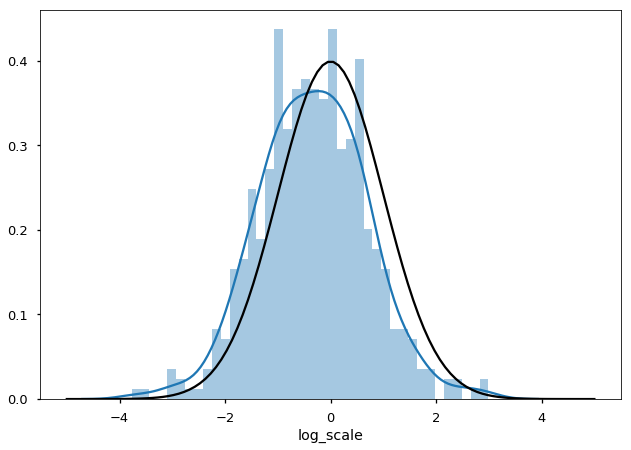

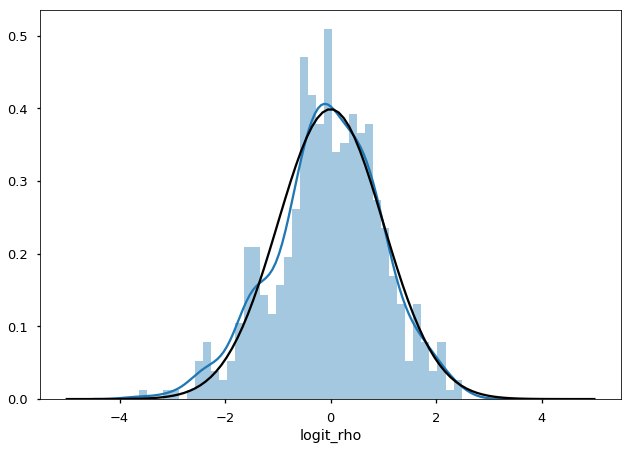

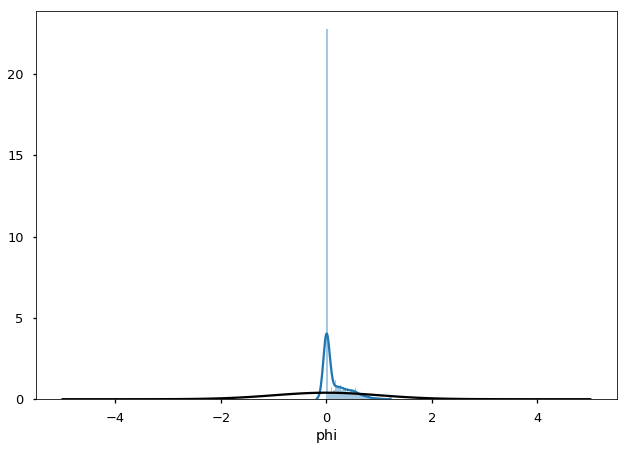

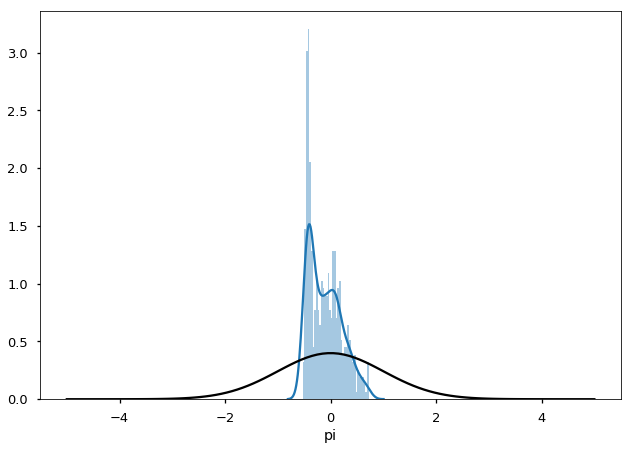

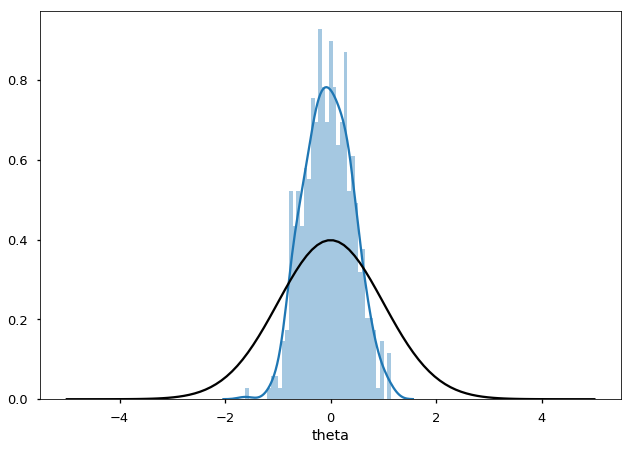

In [52]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
        if max(ax.get_xlim()) > 20:
            ax.set_xlim(-20, 20)

In [53]:
est = est_arr[0]

In [54]:
names = ['beta', 'gamma', 'log_both', 'logit_rho', 'psi', 'zeta']

In [55]:
est[1].loc[names, names]

,beta,gamma,log_both,logit_rho,psi,zeta
beta,0.019020,-3.808228e-05,0.000000,0.000000,-0.015650,0.000000
gamma,-0.000038,2.509811e-07,0.000000,0.000000,0.000016,0.000000
log_both,0.000000,0.000000e+00,0.005555,-0.006141,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.006141,0.017375,0.000000,0.000000
psi,-0.015650,1.607374e-05,0.000000,0.000000,0.050920,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000675


In [57]:
omega_cov

,beta,gamma,log_both,log_scale,logit_rho,psi,zeta
beta,0.008676,-2.770054e-05,0.000000,0.000000,0.000000,-0.006580,0.000000
gamma,-0.000028,2.746010e-07,0.000000,0.000000,0.000000,0.000007,0.000000
log_both,0.000000,0.000000e+00,0.007787,0.000996,-0.008862,0.000000,0.000000
log_scale,0.000000,0.000000e+00,0.000996,0.003099,0.000618,0.000000,0.000000
logit_rho,0.000000,0.000000e+00,-0.008862,0.000618,0.022072,0.000000,0.000000
psi,-0.006580,6.997692e-06,0.000000,0.000000,0.000000,0.036989,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000715


In [58]:
st_params = total_true_params['phi'], total_true_params['pi'], total_true_params['theta']

In [59]:
vl._covariance_kernel(*st_params, *st_params, omega['log_both'], omega['log_scale'],
                                omega['logit_rho'],omega_cov , omega['psi'])

array([[ 4.399e-02, -1.095e-05,  3.389e-02,  0.000e+00],
       [-1.095e-05,  1.586e-06,  1.347e-04,  0.000e+00],
       [ 3.389e-02,  1.347e-04,  5.275e-02,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  7.148e-04]])

In [60]:
def link_function_t_stats(est):
    params = est[0]
    st_params = (-0.4, -10, 1.768)
    rf_names = ['beta', 'gamma', 'log_both', 'log_scale', 'logit_rho', 'psi', 'zeta']
    link = vl.link_total(*st_params, params['beta'], params['gamma'], params['log_both'], params['log_scale'],
                        params['logit_rho'], params['psi'], params['zeta'])
    cov_in = est[1].loc[rf_names, rf_names]
    
    cov = vl._covariance_kernel(*st_params, *st_params, params['log_both'], params['log_scale'],
                                params['logit_rho'],cov_in , params['psi'])
    
    return link /  np.diag(cov)**.5

In [61]:
link_t_stats = np.array([link_function_t_stats(est) for est in tqdm.tqdm_notebook(est_arr)])

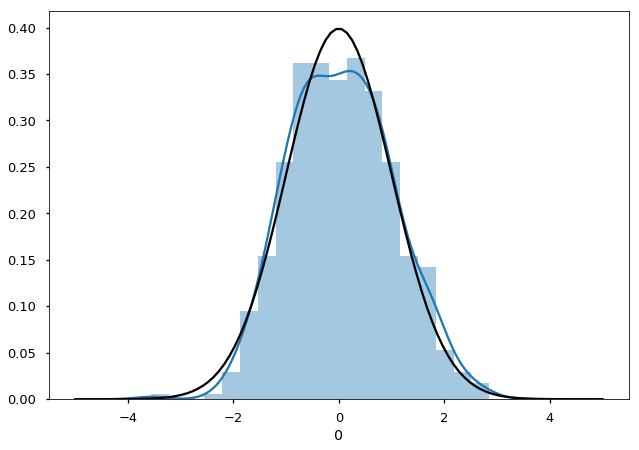

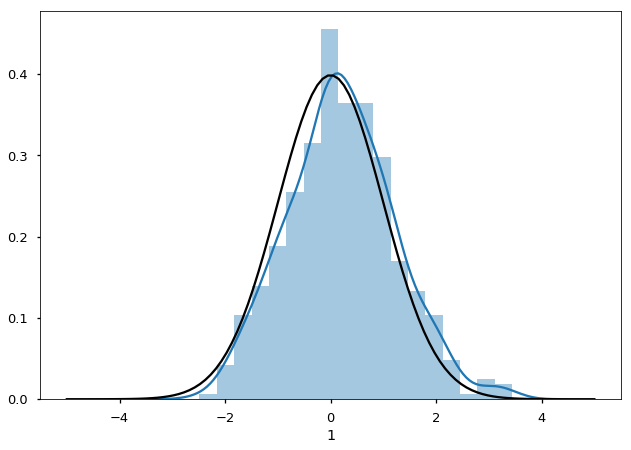

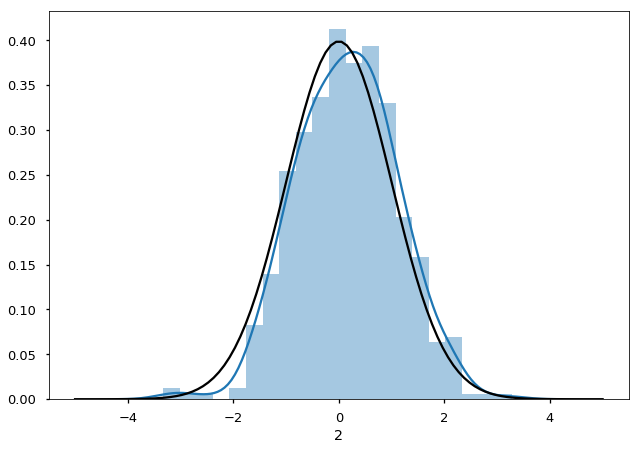

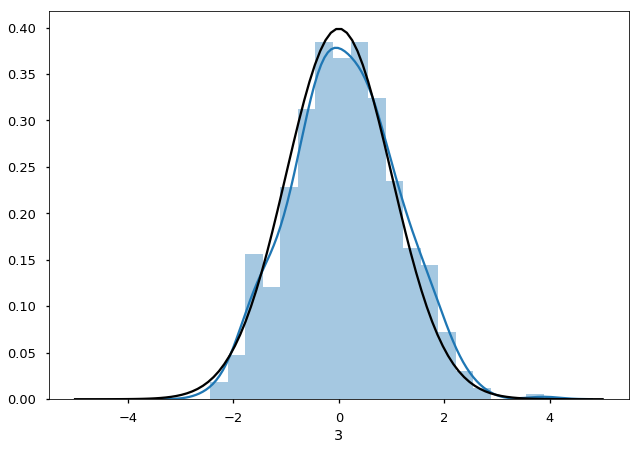

In [62]:
for key, col in enumerate(link_t_stats.T):
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

    ax.set_xlabel(key)

In [63]:
rf_names = ['log_scale', 'logit_rho', 'log_both', 'beta', 'gamma', 'zeta', 'psi']

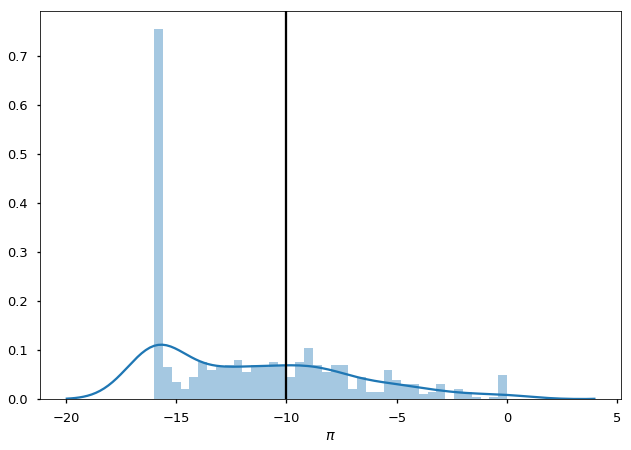

In [64]:
fig, ax = mpl.pyplot.subplots()       
sns.distplot(pd.Series([est['pi'] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
ax.axvline(total_true_params['pi'], color='black')
ax.set_xlabel('$\pi$')
fig.savefig('../doc/figures/pi_est_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
                        frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [65]:
omega

{'gamma': 0.01240077376681976,
 'beta': 4.021463897062466,
 'psi': -3.351154674630051,
 'zeta': 0.820626940191704,
 'log_both': -6.025609097298583,
 'log_scale': -5.53840359676506,
 'logit_rho': 1.5119445371154698}

In [66]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'logit_rho': 1.3862943611198908,
 'log_both': -5.97088622074413}

In [67]:
def compute_ar(params):
    param_est, param_cov = params
    names = vl.compute_names()
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov)

In [68]:
param_est, param_cov = est_arr[0]
names = vl.compute_names()
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]

In [69]:
compute_ar(est_arr[0])

3.878315780439215

In [70]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [71]:
ar_results.head()

,0
0,2.802681
1,6.015833
2,2.054123
3,3.878316
4,1.768102


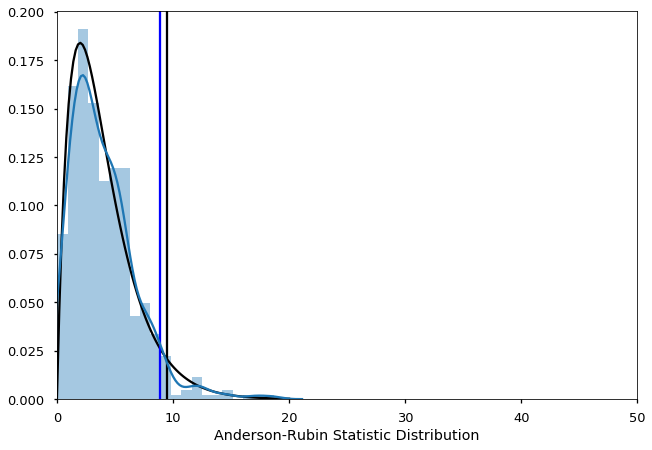

In [72]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('Anderson-Rubin Statistic Distribution')
    ax.set_xlim(0, 50)
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    ax.axvline(np.percentile(ar_results, 95), color='blue')
    sns.distplot(ar_results, ax=ax)

In [73]:
omega

{'gamma': 0.012068059460027532,
 'beta': 4.252807858693528,
 'psi': -3.488279083164138,
 'zeta': 0.8389338637374324,
 'log_both': -6.0280060732521425,
 'log_scale': -5.543871935017391,
 'logit_rho': 1.312991223565854}

In [74]:
true_prices

[-0.4, -10, 1.768]

In [75]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=innov_dim, alpha=None, robust_quantile=True, bounds=bounds)

In [76]:
total=min(100, len(est_arr))
with Pool(8) as pool:
    results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
                                                                                    est_arr[:total]),
                                                          total=total))))

In [77]:
results[results <=0] = 0 

In [78]:
robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [82]:
standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

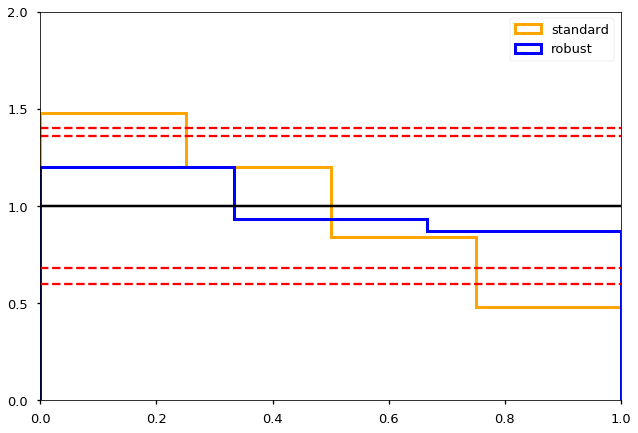

In [83]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='standard')
cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
              label='robust')
ax.legend()
fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [84]:
# with pd.option_context('mode.use_inf_as_null', True):
#     fig, ax = mpl.pyplot.subplots()       
#     ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')
#     sns.distplot(qlr_draws, ax=ax)
#     sns.distplot(returnval.qlr_stat, color='orange')
#     ax.set_xlabel('AR Statistic Distribution')
#     ax.set_xlim(0, 20)
#     ax.axvline(np.percentile(returnval.qlr_stat, q=95), color='orange')
#     ax.axvline(np.percentile(qlr_draws, q=95), color='blue')

#     ax.axvline(stats.chi2.ppf(df=4, q=.95), color='black')
    

In [85]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, 
                                        robust_quantile=True, bounds=bounds)

In [86]:
returnval.median()

qlr_stat               1.522222
robust_qlr_qauntile    3.401125
robust                 0.000000
standard               0.000000
dtype: float64

In [87]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,1.251818,1.726442,False,False
1,0.707828,2.007552,False,False
2,2.878810,5.971837,False,False
3,2.203225,2.753076,False,False
4,3.868169,4.994179,False,False


In [88]:
returnval.mean()

qlr_stat               2.098555
robust_qlr_qauntile    3.945185
robust                 0.074000
standard               0.016000
dtype: float64

In [89]:
np.percentile(returnval.qlr_stat, 95)

5.938482955694375

In [90]:
returnval.head()

,qlr_stat,robust_qlr_qauntile,robust,standard
0,1.251818,1.726442,False,False
1,0.707828,2.007552,False,False
2,2.878810,5.971837,False,False
3,2.203225,2.753076,False,False
4,3.868169,4.994179,False,False


In [91]:
returnval.mean()

qlr_stat               2.098555
robust_qlr_qauntile    3.945185
robust                 0.074000
standard               0.016000
dtype: float64

In [92]:
true_params['phi']

-0.4

In [93]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.tmp.json'.format(innov_dim, true_params['phi'], time_dim)
    
returnval.to_json(filename)

In [94]:
returnval.mean()

qlr_stat               2.098555
robust_qlr_qauntile    3.945185
robust                 0.074000
standard               0.016000
dtype: float64

In [95]:
returnval.query('robust_qlr_qauntile > 0').mean()

qlr_stat               2.102703
robust_qlr_qauntile    3.953091
robust                 0.072144
standard               0.016032
dtype: float64

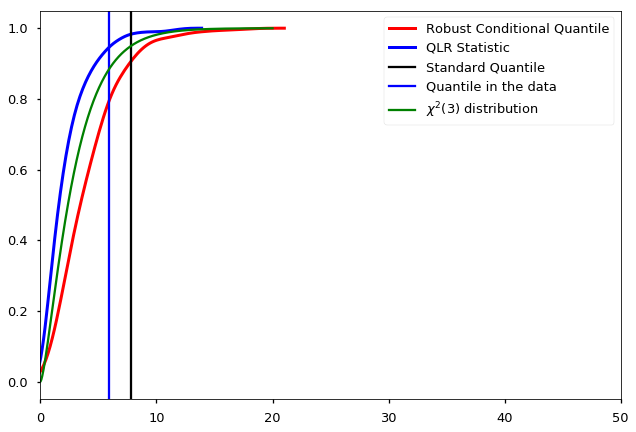

In [96]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)